# Clustering on TruncatedSVD Word Occurence Matrix (Part II)


## Data Source: 

**The preprocessing step has produced final.sqlite file after doing the data preparation & clearning.** The review text is now devoid of punctuations, HTML markups and stop words.

## Objective:

To **find clusters of semantically related words** from Amazon reviews using contextual Word Co-occurence matrix. **Co-occurence Matrix is factor decomposed using SVD, truncated with an estimated K on the basis of maximum explained variance. **


## Steps

a) Found **Top Features based on TF-IDF featurization.**

b) Created **Word Co-Occurence Matrix with neighbourhood = 5**

c) Word Co-Occurence Matrix **Decomposition done using SVD. Found matrix, U.**

d) Found the best value of **'k', based on explained variance of matrix, U** (same as in PCA).

e) Done **TruncatedSVD on U to find Word Vectors** (Reduced U to 'k' components)

f) **Ran K-means Clustering** on Standardized Word Vectors to find clusters. 

g) Took one word, found the cluster to which it belongs & found the most similar words using cosine similarity metric.

h) Draw word cloud based on cosine similarity. Do step (g) & (h) for couple of words

i) Analyze the word vector clusters obtained.

## Preprocessed Data Loading

In [1]:
import sqlite3
import pdb
import pandas as pd
import numpy as np
import nltk
import string
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.cluster import KMeans

###########################################
# Parameters to adjust in this project are:
###########################################
# Sampling Size: 'sample_size'
# Number of top 'n' terms to select: top_n 
# Estimation of K: 'k' after doing the plot estimation of K
# Cluster Size: cluster_size to group the word vectors

# This code is used to format headings 
bold = '\033[1m'
end = '\033[0m'

# SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final_unsampled = pd.read_sql_query("""
                                    SELECT *
                                    FROM Reviews
                                    """, con) 

# Set the sample size to adjust running time.
sample_size = 100000
# you can use random_state for reproducibility
final = final_unsampled#.sample(n=sample_size, random_state=2)

print(final.head(20)['CleanedText'])


0     b'witti littl book make son laugh loud recit c...
1     b'grew read sendak book watch realli rosi movi...
2     b'fun way children learn month year learn poem...
3     b'great littl book read nice rhythm well good ...
4     b'book poetri month year goe month cute littl ...
5     b'charm rhyme book describ circumst eat dont c...
6     b'set asid least hour day read son point consi...
7     b'rememb book childhood got kid good rememb ki...
8     b'great book ador illustr true classic kid lov...
9     b'book famili favorit read children small orde...
10    b'get movi sound track sing along carol king g...
11    b'author wrote wild thing carol king wrote gre...
12    b'great book perfect condit arriv short amount...
13    b'ive alway love chicken soup rice late ethel ...
14    b'book purchas birthday gift year old boy sque...
15    b'year old daughter brought book home school l...
16    b'book contain collect twelv short statement e...
17    b'young boy describ use chicken soup rice 

# Custom Defined Functions

2 user defined functions are written to 

    a) Elbow Method to find K
    
    b) Analyze the Clusters function
    
    c) Generate Similiarity Word Clouds

## a) Elbow Method to find K


In [59]:
# To find K of K-means using elbow method.
# This fn plots the loss vs k graph to find the elbow point

def findK(d_vect_std):
    
    sse = {}
    for k in range(2, 50):
        kmeans = KMeans(n_clusters=k, max_iter=300, random_state=5).fit(d_vect_std)

#         print(bold+"\nGroup Counter in Cluster %d is as follows:" % (k) +end)
#         print(collections.Counter(kmeans.labels_))

        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("Loss Value")
    plt.show()


## b) Analyze the Clusters

In [60]:
# Using elbow method, optimal k is found. 
# This function analyze the clusters so formed.

def analyzeClusters(data, d_labels, k):

    count = collections.Counter(d_labels)

#     print(bold+"\n*** CLUSTERS FORMED BY K-MEANS 
#           ALGORITHM is as follows: ***" + end)

    for i in range(0, k):
#         print("\n\nCLUSTER = " + str(i))
        # if point is noise then cluster index will be -1. hence exclude.
        if(count.get(i) > 1):
            
            cluster_data = data[d_labels == i]
            cSize = len(cluster_data)

#             print(bold+"\nThe Review Text in Cluster %d of 
#                                 size %d is as follows:" % (i, cSize) +end)
#             print(cluster_data.head(100))
    
        else:
            print("Not enough datapoints to display in this cluster!")


## c) Generate Similarity Word Clouds

In [4]:
# Self-written function to pick up one word from a cluster and compare with all 
# the words in the cluster using cosine similarity of word vectors and display 
# the word cloud to understand what the cluster represents.

from wordcloud import WordCloud
from scipy import spatial

# To check the 'n' similar words to a specific word in cluster 'k'
def genSimilarWordsCloud (data, d_labels, cluster_num = 1, 
                              word = 'breakfast', n_mostSimilar = 80):
        # Get the features (words) and labels (cluster number).
#         data = pd.DataFrame(top_features)
#         d_labels = kmeans.labels_

        # Get the words in the cluster and corresponding word vectors
        cluster = data[d_labels == cluster_num]
        w2v = word_vectors[d_labels == cluster_num]

        cluster_size = len(cluster)
        print("cluster length = " + str(cluster_size))

        # Find the word vector of selected word, from cluster.
        for i in range(0, cluster_size-1):
            if (cluster.iloc[i].get(0) == word):

                vec1 = w2v[i]
                break

        dist = []

        # Find words similar in cosine distance to a specific word
        for i in range(0, len(w2v)-1):

            vec2 = w2v[i]

            # spatial.distance.cosine computes the distance, and not the similarity.
            # Hence find the vectors with least distance
            dist.append(spatial.distance.cosine(vec1, vec2))

        # find 'n' words with minimum distance
        minindices = np.argsort(dist)[:n_mostSimilar]
        similar_words = cluster.take(minindices)
        #sort the distances array to match corresponding elements to similar_words
        dist.sort()
        dist_words = dist[:n_mostSimilar]

        d = {}

        # create a dictionary of word, similarity = 1/distance
        for i in range(0, len(similar_words)-1):
            if dist_words[i] != 0:
        #         print(str(similar_words.iloc[i].get(0)) + "-" + str(dist_words[i]))
                d[similar_words.iloc[i].get(0)] = 1/dist_words[i]

        # create the word cloud with feature importance as the scaling factor
        wordcloud = WordCloud(width=2200,height=1200, 
                      max_words=2000,relative_scaling=1,
                      normalize_plurals=False).generate_from_frequencies(d)

        plt.figure(figsize =[16, 12])
        plt.title("\nMost Important Features in Cluster = %d, 
                          similar to word '%s':" % (cluster_num, word))

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()


# Find Top Features based on TF-IDF vectors

In [5]:
# Code for top 'n' words from tf-idf vectors is sourced from here:
# https://stackoverflow.com/questions/25217510/how-to-see-top-n-entries-of-term-document-matrix-after-tfidf-in-scikit-learn

# top 'n' words from tf-idf vectors TF-IDF

# Number of top 'n' terms to select
top_n = 20000

tf_idf_vect = TfidfVectorizer(max_features = top_n)
final_tf_idf = tf_idf_vect.fit_transform(
                    final['CleanedText'].values)
print(final_tf_idf.get_shape)

# The global term weighting of the features learnt by a TfidfVectorizer 
# can be accessed through the attribute idf_, which will return an array 
# of length equal to the feature dimension. The values in attribute idf_ 
# represents inverse document frequency, i.e. the value will be more if the 
# word is rare in the document. Sort the  features by this idf
# weighting to get the top weighted (most rare) features:

# indices = np.argsort(tf_idf_vect.idf_)[::-1]
# features = tf_idf_vect.get_feature_names()

# top_features = [features[i] for i in indices[:top_n]]
# print(top_features[:20])

top_features = tf_idf_vect.get_feature_names()


<bound method spmatrix.get_shape of <364171x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 11380652 stored elements in Compressed Sparse Row format>>


# Create Word Co-Occurence Matrix

In [6]:
# code stub for occurence matrix sourced from here:
# https://datascience.stackexchange.com/questions/40038/how-to-implement-word-to-word-co-occurence-matrix-in-python
# Modified to create matrix to feed SVD

from nltk.tokenize import word_tokenize
from itertools import combinations
from collections import Counter

import pandas as pd
import nltk
nltk.download('punkt')

reviews_bin = final['CleanedText'].values
reviews = [review.decode("utf-8") for review in reviews_bin]

vocab = top_features 
review_list = [word_tokenize(review) for review in reviews]

co_occ = {ii:Counter({jj:0 for jj in vocab if jj!=ii}) for ii in vocab}
# k is the window length
k=5

# if the word in review is not among top features then we can ignore
# There is no need to include it in the word co-occurence matrix.
# That is the reason to check whether review[ii] is in top_features

for review in review_list:
    for ii in range(len(review)):
        if review[ii] in top_features:
            if ii < k:
                c = Counter(review[0:ii+k+1])
                del c[review[ii]]
                co_occ[review[ii]] = co_occ[review[ii]] + c

            elif ii > len(review)-(k+1):
                c = Counter(review[ii-k::])
                del c[review[ii]]
                co_occ[review[ii]] = co_occ[review[ii]] + c
            else:
                c = Counter(review[ii-k:ii+k+1])
                del c[review[ii]]
                co_occ[review[ii]] = co_occ[review[ii]] + c


# create word matrix in list of lists format
word_matrix = []
for word_row in vocab:
    word_occ = []
    word_occ_dict = co_occ.get(word_row)
    for word_col in vocab:
        # 0 is the default value (if not present in dict)
        occurences = word_occ_dict.get(word_col, 0)
        word_occ.append(occurences)
    word_matrix.append(word_occ)

# print("Word Co-Occurence Matrix")
word_coocc_mat = pd.DataFrame(word_matrix)
print("Word occurence matrix with window=5 created.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Word occurence matrix with window=5 created.


# Word Co-Occurence Matrix Decomposition using SVD & K Estimation

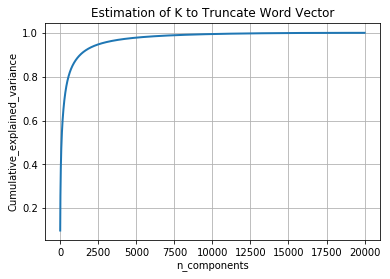

In [7]:
# Decompose word vectors and estimation of optimum vector length

# TruncatedSVD is basically a wrapper around sklearn.utils.extmath.randomized_svd 

# from sklearn.utils.extmath import randomized_svd
# U, Sigma, VT = randomized_svd(word_matrix, n_components=5, n_iter=5, random_state=5)

# Decomposing word co-occurence matrix into factors using SVD
from scipy.linalg import svd
U, Sigma, VT = svd(word_coocc_mat)

# Trying to find the best value of K, based on explained variance.
percentage_var_explained = Sigma / np.sum(Sigma)
# here we analyze singular values, the same way as we analyze lambda in PCA.
# in PCA we have used eigen values, in SVD, we use singular values.
cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.title('Estimation of K to Truncate Word Vector')
plt.show()


# Compute Word Vectors with Truncated SVD

In [8]:
# TruncatedSVD

# From the above Cumulative Variance Plot, it can be understood that,
# with n_components = 4000, more than 95% of variance is explained.
k = 4000

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=k, n_iter=10, random_state=42)
word_vectors = svd.fit_transform(U)

print('Truncatedsvd over')
# # print(data_1000.shape)

# print(svd.explained_variance_ratio_.sum())  


Truncatedsvd over


# Estimate K for K-means Clustering

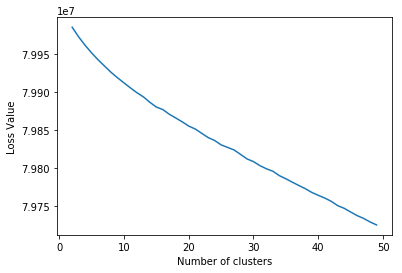

In [61]:

from sklearn.preprocessing import StandardScaler

# From the above Cumulative Variance Plot, it can be understood that,
# with n_components = 2500, more than 95% of variance is explained.
# k = 2500

# take first k components of each vector in U denotes each word
# word_vectors = U[:,:k]

# print(U.)
# print(word_vectors)

#########################################################
### TFID for K-means: Vectorization & Standardization ###
# count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
# kmeans_vect = count_vect.fit_transform(word_vectors)
# # d_kmeans_vect.get_shape()

# Standardisation. Set "with_mean=False" to preserve sparsity
scaler = StandardScaler(copy=False, with_mean=False).fit(word_vectors)
kmeans_vect_std = scaler.transform(word_vectors)

#########################################################

## Plot to find the best K for K-means 
findK(kmeans_vect_std)



# K-Means Clustering on Word Vectors

 After Truncated SVD is done, we can apply K-Means clustering and choose the best number of clusters based on elbow method. 

In [62]:
# To analyze clusters formed by kmeans clustering on truncated word vectors

# Analyse review in all clusters. 
# cluster_size is found using elbow method plot above.
# from the above elbow plot, cluster_size = 31 is found to be optimum for K-means

cluster_size = 20
pd.options.display.max_colwidth = 200

# Do K-Means based on the cluster size found.
kmeans = KMeans(n_clusters=cluster_size, 
                max_iter=300, random_state=5).fit(kmeans_vect_std)

# Analyze clusters formed by kmeans clustering
analyzeClusters(data=pd.DataFrame(top_features), 
                d_labels=kmeans.labels_, k=cluster_size)

print('k-means clustering over')

k-means clustering over


# Word Clouds using Cosine Similarity

Taken couple of words & found the cluster to which it belongs. Then found the most similar words to the selected word using cosine similarity metric to analyze cluster behaviour.

In [29]:
def findCluster(word):

    count = top_features.count(word)
    if count > 0:
        return kmeans.labels_[top_features.index(word)]
    else:
        return -1

cluster length = 382


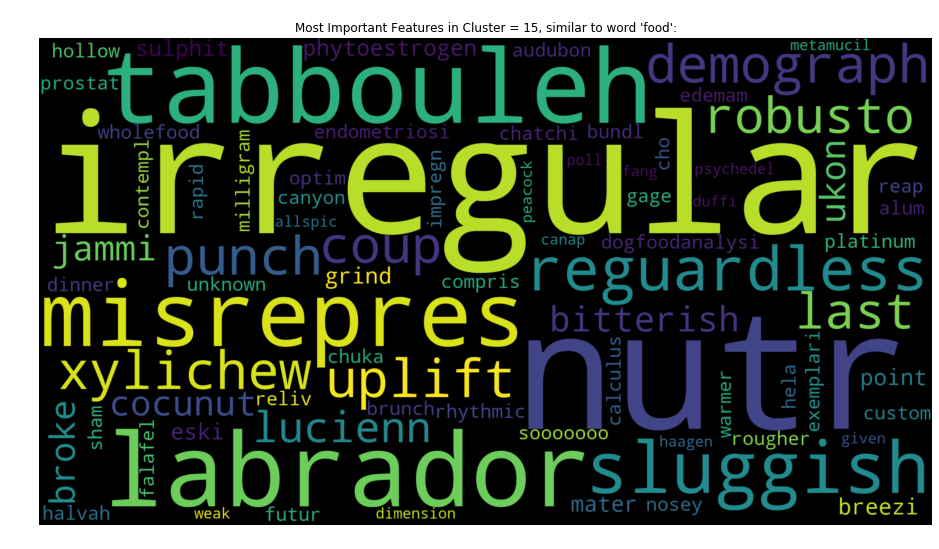

In [58]:
# Take some word, find the cluster to which it belongs and find the most 
# similar words to that word that is taken using cosine similarity. 
# find 'k' most similar words, and represent them in a word cloud

word = 'food'
clusterFound = findCluster(word)

genSimilarWordsCloud (pd.DataFrame(top_features), kmeans.labels_, 
                              clusterFound, word, n_mostSimilar = 80)


The words meaningfully similar to 'food' in cluster 15 are irregular, wholefood, brunch, bitterish, grind, robusto, dogfoodanalyst, dinner, cocunut etc. Thus 15th cluster contains food and food related words in general.

cluster length = 917


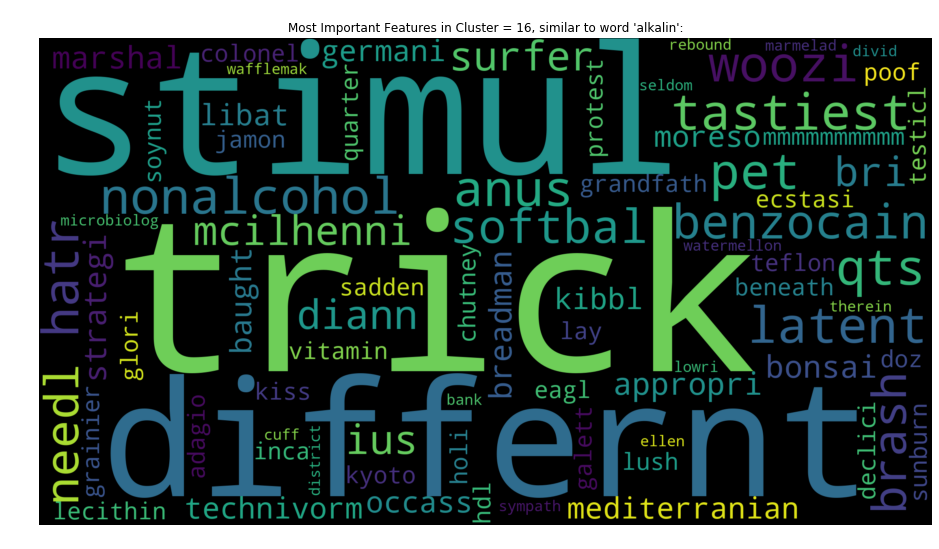

In [57]:
# Next word to find similarity
word = 'alkalin'
clusterFound = findCluster(word)

genSimilarWordsCloud (pd.DataFrame(top_features), kmeans.labels_, 
                              clusterFound, word, n_mostSimilar = 80)

The words meaningfully similar to 'alkalin' in cluster 16 are nonalcohol, stimuli, vitamin, needl, lecithin, technivorm, latent, microbiolog, benzocain, sunburn etc. Thus 16th cluster contains chemcial and medicine related words.

cluster length = 1359


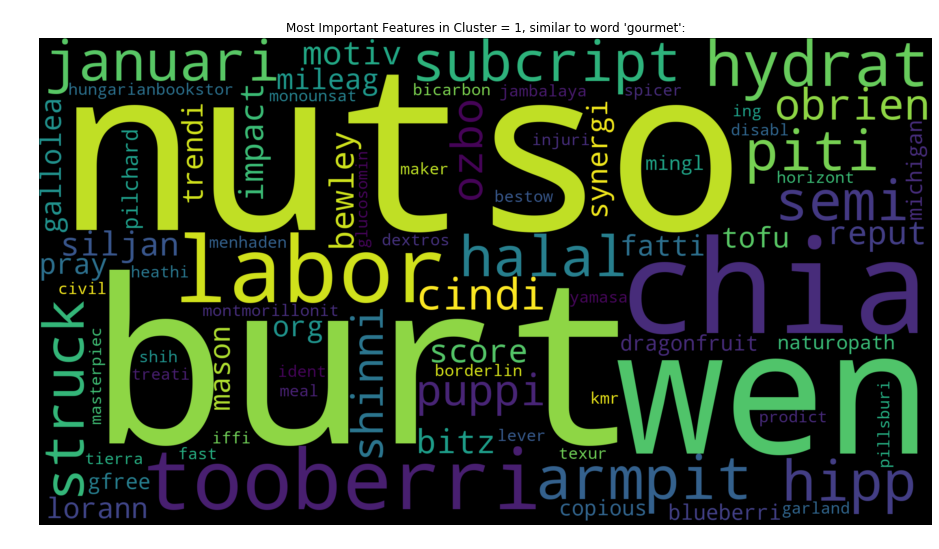

In [54]:
# Next word to find similarity
word = 'gourmet'
clusterFound = findCluster(word)

genSimilarWordsCloud (pd.DataFrame(top_features), kmeans.labels_, 
                              clusterFound, word, n_mostSimilar = 80)

The words meaningfully similar to 'gourmet' in cluster 1 are pillsburi, chia, blueberri, dragonfruit, naturopath, maker, healthi, masterpiec, halal, semi, reput, fast, fatti, pilchard etc. Thus, 1st cluster contains gourmet and food/health related words.

# Observations

a) There are clusters where semantic relation could be noticed. For instance, **words hypoglecemia and hysterectomi are grouped together (both are medical words)**.

b) The words grouped together with word, **'alkalin' in cluster 16** are nonalcohol, stimuli, vitamin, needl, lecithin, technivorm, latent, microbiolog, benzocain, sunburn etc. Thus **16th cluster contains chemcial and medicine related words.**

c) The words meaningfully similar to **'food'** in cluster 15 are irregular, wholefood, brunch, bitterish, grind, robusto, dogfoodanalyst, dinner, cocunut etc. Thus **15th cluster contains food and food related words in general.**

d) The words along with **'gourmet'** in cluster 1 are pillsburi, chia, blueberri, dragonfruit, naturopath, maker, healthi, masterpiec, halal, semi, reput, fast, fatti, pilchard etc. Thus, **1st cluster contains gourmet and food/health related words.**

e) Thus, using **factor decomposed Word Co-occurence matrix, semantically related words are clustered** from Amazon reviews.